In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

from matplotlib.sankey import Sankey
import plotly.graph_objects as go


In [2]:
current_dir = os.getcwd()
datapath = os.path.join(current_dir, "../..", 'data/outputs/DES_data.csv')

df = pd.read_csv(datapath, sep=',', index_col='date')
df.index = pd.to_datetime(df.index)
print(df.head())

                     PVSim-0.PV_0-P[MW]  CSV-0.DNI_0-DNI  \
date                                                       
2022-01-01 00:00:00                 0.0           -0.991   
2022-01-01 00:15:00                 0.0           -1.000   
2022-01-01 00:30:00                 0.0           -0.996   
2022-01-01 00:45:00                 0.0           -0.989   
2022-01-01 01:00:00                 0.0           -0.976   

                     CSV-1.HEATLOAD_0-T_amb  HeatPumpSim-0.HeatPump_0-T_amb  \
date                                                                          
2022-01-01 00:00:00                   6.855                           5.000   
2022-01-01 00:15:00                   6.460                           6.855   
2022-01-01 00:30:00                   6.205                           6.460   
2022-01-01 00:45:00                   6.100                           6.205   
2022-01-01 01:00:00                   6.100                           6.100   

                     CSV-

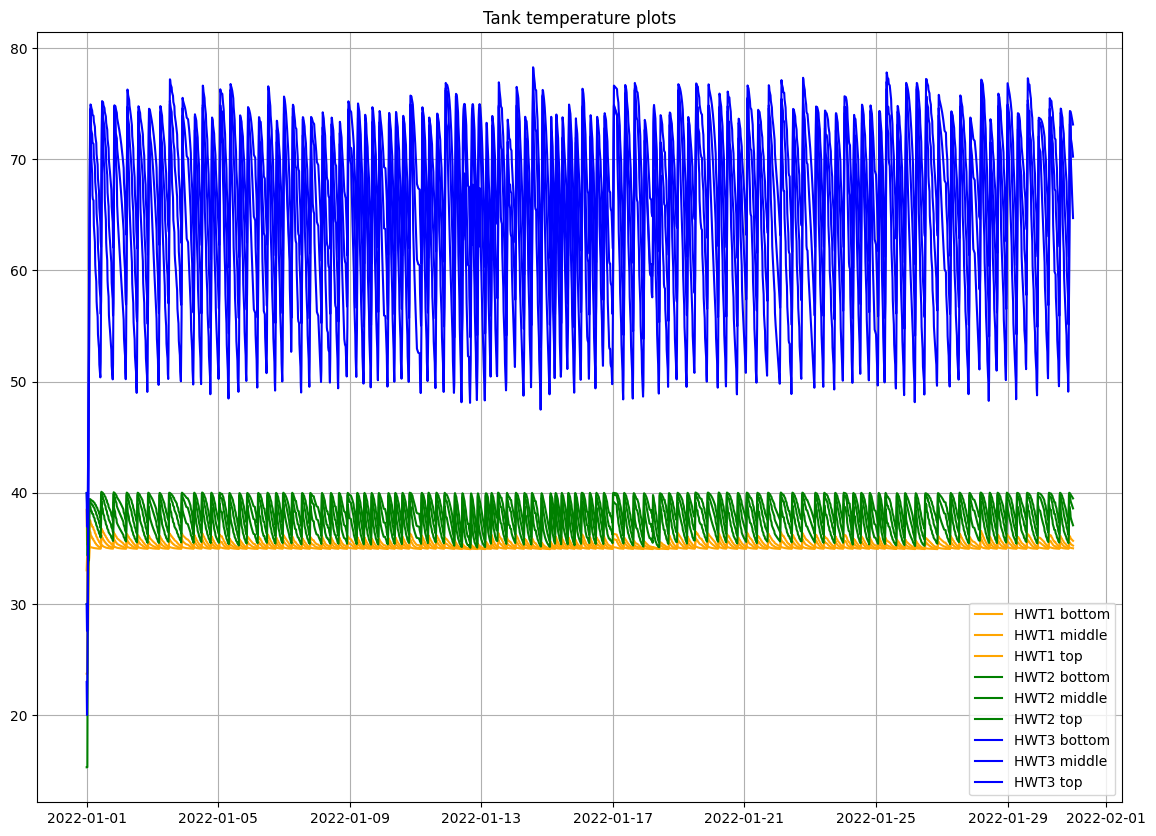

In [3]:
hwt1_cols = [col for col in df.columns if col.startswith('HotWaterTankSim-0.HotWaterTank_0-sensor')]
hwt2_cols = [col for col in df.columns if col.startswith('HotWaterTankSim-1.HotWaterTank_0-sensor')]
hwt3_cols = [col for col in df.columns if col.startswith('HotWaterTankSim-2.HotWaterTank_0-sensor')]

plt.figure(figsize=(14, 10))
plt.plot(df[hwt1_cols], label=['HWT1 bottom', 'HWT1 middle', 'HWT1 top'], color = 'orange')
plt.plot(df[hwt2_cols], label=['HWT2 bottom', 'HWT2 middle', 'HWT2 top'], color = 'green')
plt.plot(df[hwt3_cols], label=['HWT3 bottom', 'HWT3 middle', 'HWT3 top'], color = 'blue')

plt.title("Tank temperature plots")
plt.grid()
plt.legend()
plt.show()

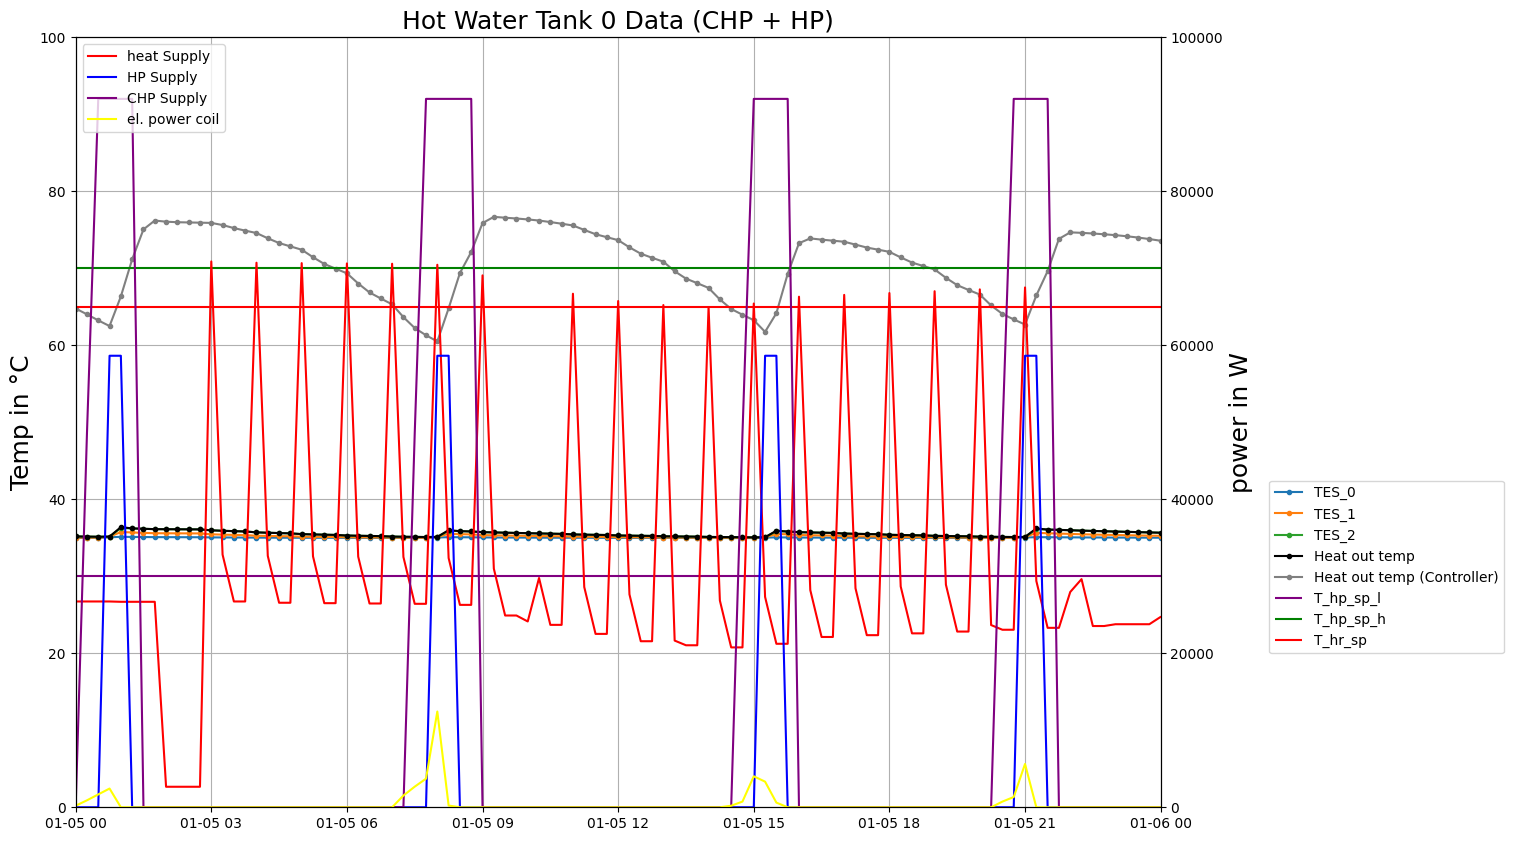

In [4]:
params_ctrl = {
    'T_hp_sp_h': 70,
    'T_hp_sp_l': 30,
    'T_hr_sp': 65,
    'operation_mode': 'heating',
    'control_strategy': '3'
}

hot_water_tank_columns = [col for col in df.columns if col.startswith('HotWaterTankSim-0.HotWaterTank_0-sensor')]

plt.figure(figsize=(14, 10))

# Plotting the hot water tank data
plt.plot(df[hot_water_tank_columns], label=['TES_0', 'TES_1', 'TES_2'], marker='.')
plt.plot(df['HotWaterTankSim-0.HotWaterTank_0-heat_out.T'], color='black', label='Heat out temp', marker='.')
plt.plot(df['ControllerSim-0.Controller_0-heat_out_T'], color='grey', label='Heat out temp (Controller)', marker='.')

# Plotting horizontal lines
plt.hlines(params_ctrl['T_hp_sp_l'], 1000, 9999999, label='T_hp_sp_l', color='purple')
plt.hlines(params_ctrl['T_hp_sp_h'], 1000, 9999999, label='T_hp_sp_h', color='green')
plt.hlines(params_ctrl['T_hr_sp'], 1000, 9999999, label='T_hr_sp', color='red')


# Primary y-axis
plt.ylabel('Temp in °C', fontsize=18)
plt.title('Hot Water Tank 0 Data (CHP + HP)', fontsize=18)
plt.grid()
plt.xlim([datetime.date(2022, 1, 5), datetime.date(2022, 1, 6)])
plt.ylim(0,100)
plt.legend(loc=(1.1, 0.2))

# Create secondary y-axis for sh_demand
ax2 = plt.gca().twinx()
ax2.plot(df.index, df['ControllerSim-0.Controller_0-heat_demand'], color='red', label='heat Supply')
ax2.plot(df.index, df['ControllerSim-0.Controller_0-hp_supply'], color='blue', label='HP Supply')
ax2.plot(df.index, df['ControllerSim-0.Controller_0-chp_supply'], color='purple', label='CHP Supply')
ax2.plot(df.index, df['ControllerSim-0.Controller_0-P_hr'], color='yellow', label='el. power coil')
ax2.set_ylabel('power in W', fontsize=18)
ax2.tick_params(axis='y')
ax2.set_ylim(0,100_000)

# Combining legends from both axes
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(labels + labels2, loc='upper left')

plt.show()

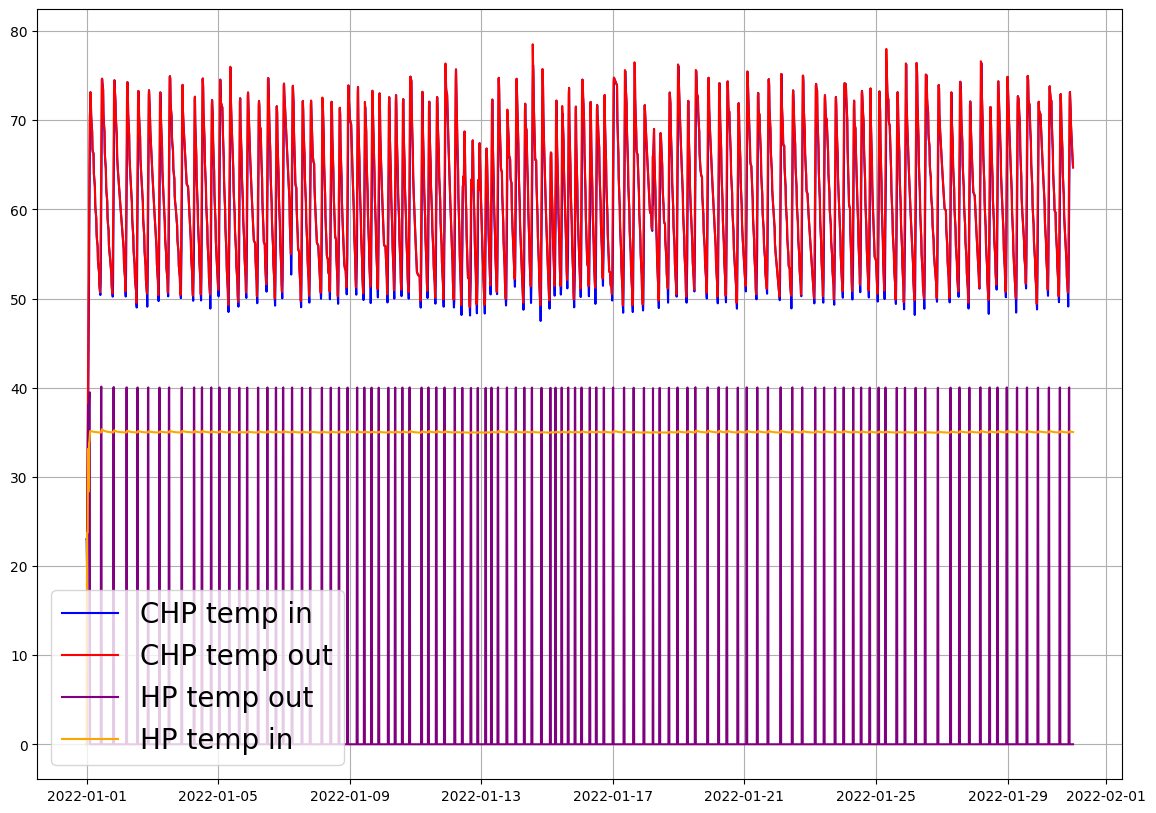

In [5]:
plt.figure(figsize=(14, 10))
plt.plot(df['CHPSim-0.CHP_0-temp_in'], color='blue', label='CHP temp in')
plt.plot(df['CHPSim-0.CHP_0-temp_out'], color='red', label='CHP temp out')
plt.plot(df['HeatPumpSim-0.HeatPump_0-cons_T'], color='purple', label='HP temp out')
plt.plot(df['HeatPumpSim-0.HeatPump_0-cond_in_T'], color='orange', label='HP temp in')

plt.grid()
plt.legend(fontsize=20)
plt.show()

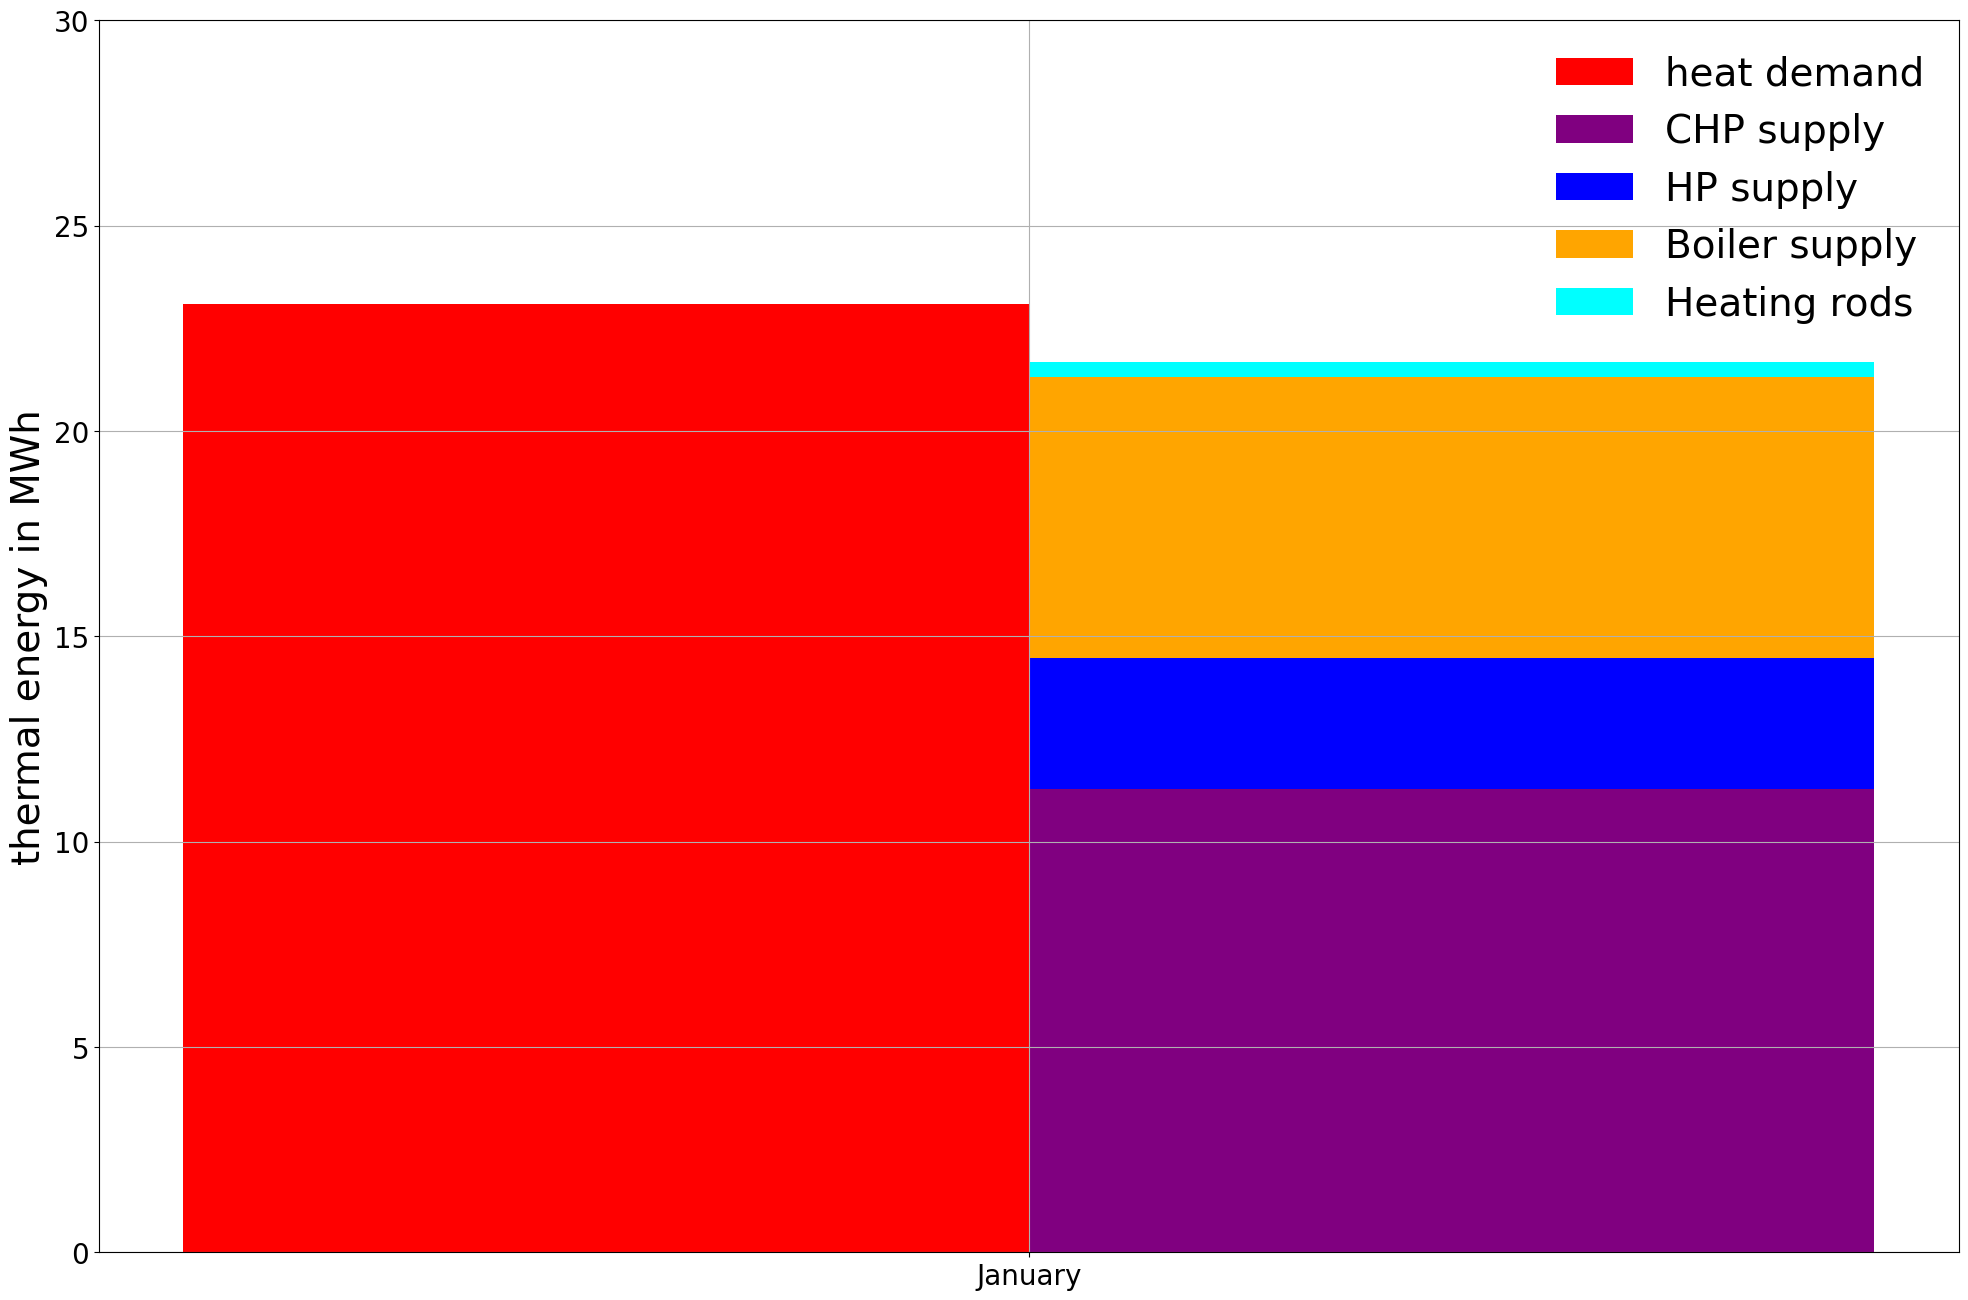

In [6]:
df_monthly = df.resample('M').sum()/4

# Generate the positions for the bars
months = df_monthly.index.month_name()
x = np.arange(len(months))  # the label locations
width = 0.35  # the width of the bars

# Create the figure and the bar plots
plt.figure(figsize=(24, 16))

# Plot heat demand on the left
plt.bar(
    x - width/2, 
    df_monthly['ControllerSim-0.Controller_0-heat_demand']/1_000_000, 
    width=width, 
    color='red', 
    label='heat demand', 
)

# Plot CHP supply stacked with HP supply on the right
plt.bar(
    x + width/2, 
    df_monthly['ControllerSim-0.Controller_0-chp_supply']/1_000_000, 
    width=width, 
    color='purple', 
    label='CHP supply', 
)
plt.bar(
    x + width/2, 
    df_monthly['ControllerSim-0.Controller_0-hp_supply']/1_000_000, 
    width=width, 
    color='blue', 
    label='HP supply', 
    bottom=df_monthly['ControllerSim-0.Controller_0-chp_supply']/1_000_000
)

plt.bar(
    x + width/2, 
    df_monthly['Boilersim-0.BOILER_0-P_th']/1_000_000, 
    width=width, 
    color='orange', 
    label='Boiler supply', 
    bottom=(df_monthly['ControllerSim-0.Controller_0-chp_supply'] + df_monthly['ControllerSim-0.Controller_0-hp_supply'])/1_000_000
)

plt.bar(
    x + width/2, 
    df_monthly['ControllerSim-0.Controller_0-P_hr']/1_000_000, 
    width=width, 
    color='cyan', 
    label='Heating rods', 
    bottom=(df_monthly['ControllerSim-0.Controller_0-chp_supply'] + df_monthly['ControllerSim-0.Controller_0-hp_supply'] + df_monthly['Boilersim-0.BOILER_0-P_th'])/1_000_000
)

# Set x-ticks and labels
plt.xticks(x, months, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('thermal energy in MWh', fontsize=28)
plt.ylim(0,30)
plt.grid()

# Set the legend
plt.legend(fontsize=28, frameon=False)

# Display the plot
plt.show()

# PV plots

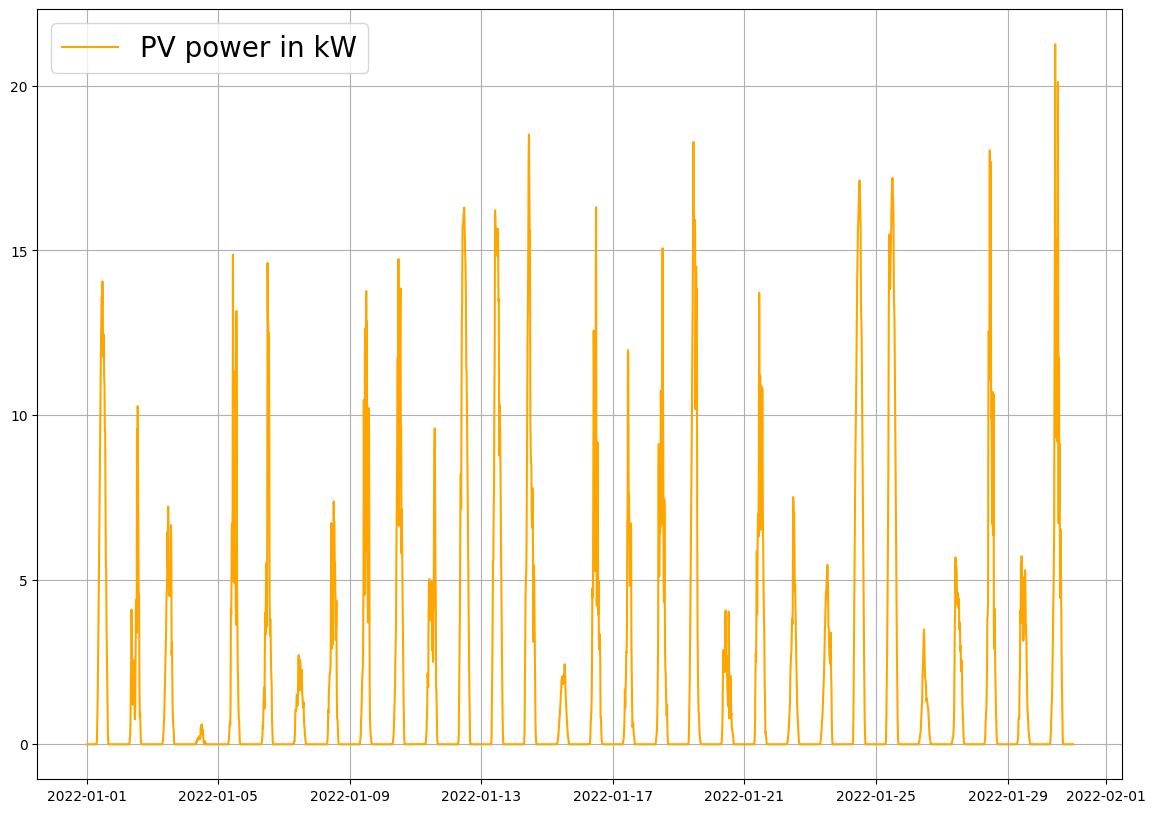

In [7]:
plt.figure(figsize=(14, 10))

plt.plot(df['PVSim-0.PV_0-P[MW]']*1000, color='orange', label='PV power in kW')
# plt.title('Energy flows', fontsize=30, y=1.05)
plt.grid()
plt.legend(fontsize=20)
plt.show()


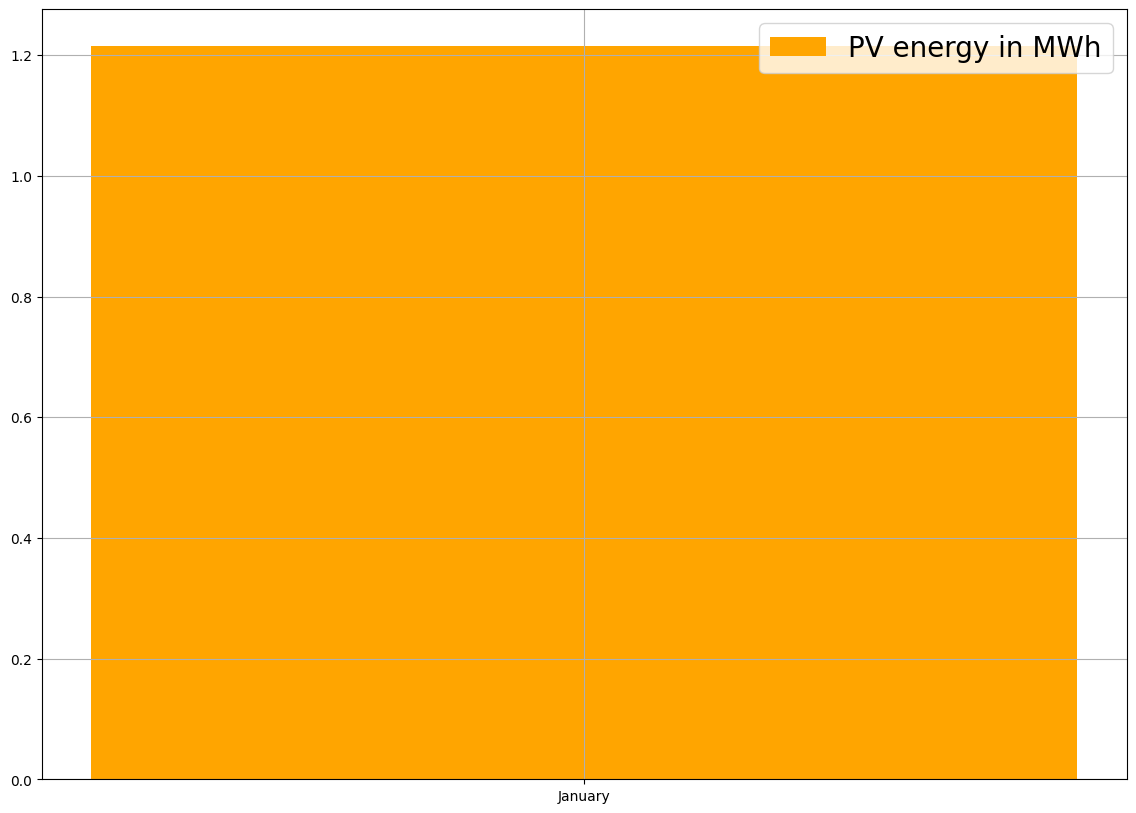

In [8]:
plt.figure(figsize=(14, 10))

plt.bar(months, df_monthly['PVSim-0.PV_0-P[MW]'], color='orange', label='PV energy in MWh')
# plt.title('Energy flows', fontsize=30, y=1.05)
plt.grid()
plt.legend(fontsize=20)
plt.show()

# Column translations

In [9]:
columnname = {'PVSim-0.PV_0-P[MW]': 'PV_P[MW]', 'CSV-0.DNI_0-DNI': 'DNI', 'CSV-1.HEATLOAD_0-T_amb':'T_amb', 'HeatPumpSim-0.HeatPump_0-T_amb' : 'HP_Tamb', 'CSV-1.HEATLOAD_0-Heat Demand [kW]':'Heat Demand [KW]',
       'HeatPumpSim-0.HeatPump_0-Q_Demand' : 'HP_Q_Demand', 'CHPSim-0.CHP_0-Q_Demand':'CHP_Q_Demand',
       'HeatPumpSim-0.HeatPump_0-Q_Supplied' : 'HP_Q_Supplied',
       'HeatPumpSim-0.HeatPump_0-heat_source_T' : 'HP_heat_sourceT',
       'HeatPumpSim-0.HeatPump_0-cons_T' : 'HP_consT',
       'HeatPumpSim-0.HeatPump_0-P_Required': 'HP_P_Required', 'HeatPumpSim-0.HeatPump_0-COP':'HP_COP',
       'HeatPumpSim-0.HeatPump_0-cond_m':'HP_cond_m', 'HeatPumpSim-0.HeatPump_0-cond_in_T':'HP_cond_in_T',
       'HeatPumpSim-0.HeatPump_0-on_fraction':'HP_onfraction',
       'ControllerSim-0.Controller_0-heat_demand':'heat_demand',
       'ControllerSim-0.Controller_0-heat_supply':'heat_supply',
       'ControllerSim-0.Controller_0-hp_demand':'hp_demand',
       'ControllerSim-0.Controller_0-hp_supply':'hp_supply',
       'ControllerSim-0.Controller_0-chp_demand':'chp_demand',
       'ControllerSim-0.Controller_0-chp_supply':'chp_supply',
       'ControllerSim-0.Controller_0-heat_in_F':'heatin_F',
       'ControllerSim-0.Controller_0-heat_in_T':'heatin_T',
       'ControllerSim-0.Controller_0-heat_out_F':'heatout_F',
       'ControllerSim-0.Controller_0-heat_out_T':'heatout_T',
       'ControllerSim-0.Controller_0-chp_in_F':'chpin_F',
       'ControllerSim-0.Controller_0-chp_in_T':'chpin_T',
       'ControllerSim-0.Controller_0-chp_out_F':'chpout_F',
       'ControllerSim-0.Controller_0-chp_out_T':'chpout_T',
       'ControllerSim-0.Controller_0-hp_out_F':'hpout_F',
       'ControllerSim-0.Controller_0-hp_out_T':'hpout_T',
       'ControllerSim-0.Controller_0-P_hr':'P_hr',
       'HotWaterTankSim-0.HotWaterTank_0-sensor_00.T':'HWTSim0_sensor0_T',
       'HotWaterTankSim-1.HotWaterTank_0-sensor_00.T':'HWTSim1_sensor0_T',
       'HotWaterTankSim-2.HotWaterTank_0-sensor_00.T':'HWTSim2_sensor0_T',
       'HotWaterTankSim-0.HotWaterTank_0-sensor_01.T':'HWTSim0_sensor1_T',
       'HotWaterTankSim-1.HotWaterTank_0-sensor_01.T':'HWTSim1_sensor1_T',
       'HotWaterTankSim-2.HotWaterTank_0-sensor_01.T':'HWTSim2_sensor1_T',
       'HotWaterTankSim-0.HotWaterTank_0-sensor_02.T':'HWTSim0_sensor2_T',
       'HotWaterTankSim-1.HotWaterTank_0-sensor_02.T':'HWTSim1_sensor2_T',
       'HotWaterTankSim-2.HotWaterTank_0-sensor_02.T':'HWTSim2_sensor2_T',
       'HotWaterTankSim-0.HotWaterTank_0-heat_out.T':'HWTSim0_heatout_T',
       'HotWaterTankSim-1.HotWaterTank_0-heat_out.T':'HWTSim1_heatout_T',
       'HotWaterTankSim-2.HotWaterTank_0-heat_out.T':'HWTSim2_heatout_T',
       'HotWaterTankSim-0.HotWaterTank_0-heat_out.F':'HWTSim0_heatout_F',
       'HotWaterTankSim-1.HotWaterTank_0-heat_out.F':'HWTSim1_heatout_F',
       'HotWaterTankSim-2.HotWaterTank_0-heat_out.F':'HWTSim2_heatout_F',
       'HotWaterTankSim-0.HotWaterTank_0-hp_in.T':'HWTSim0_hp_in_T',
       'HotWaterTankSim-1.HotWaterTank_0-hp_in.T':'HWTSim1_hp_in_T',
       'HotWaterTankSim-2.HotWaterTank_0-hp_in.T':'HWTSim2_hp_in_T',
       'HotWaterTankSim-0.HotWaterTank_0-hp_in.F':'HWTSim0_hp_in_F',
       'HotWaterTankSim-1.HotWaterTank_0-hp_in.F':'HWTSim1_hp_in_F',
       'HotWaterTankSim-2.HotWaterTank_0-hp_in.F':'HWTSim2_hp_in_F',
       'HotWaterTankSim-0.HotWaterTank_0-hp_out.T':'HWTSim0_hp_out_T',
       'HotWaterTankSim-1.HotWaterTank_0-hp_out.T':'HWTSim1_hp_out_T',
       'HotWaterTankSim-2.HotWaterTank_0-hp_out.T':'HWTSim2_hp_out_T',
       'HotWaterTankSim-0.HotWaterTank_0-hp_out.F':'HWTSim0_hp_out_F',
       'HotWaterTankSim-1.HotWaterTank_0-hp_out.F':'HWTSim1_hp_out_F',
       'HotWaterTankSim-2.HotWaterTank_0-hp_out.F':'HWTSim2_hp_out_F',
       'HotWaterTankSim-0.HotWaterTank_0-heat_in.T':'HWTSim0_heatin_T',
       'HotWaterTankSim-1.HotWaterTank_0-heat_in.T':'HWTSim1_heatin_T',
       'HotWaterTankSim-2.HotWaterTank_0-heat_in.T':'HWTSim2_heatin_T',
       'HotWaterTankSim-0.HotWaterTank_0-heat_in.F':'HWTSim0_heatin_F',
       'HotWaterTankSim-1.HotWaterTank_0-heat_in.F':'HWTSim1_heatin_F',
       'HotWaterTankSim-2.HotWaterTank_0-heat_in.F':'HWTSim2_heatin_F',
       'HotWaterTankSim-0.HotWaterTank_0-T_mean':'HWTSim0_Tmean',
       'HotWaterTankSim-1.HotWaterTank_0-T_mean':'HWTSim1_Tmean',
       'HotWaterTankSim-2.HotWaterTank_0-T_mean':'HWTSim2_Tmean', 'CHPSim-0.CHP_0-eff_el':'CHP_eff',
       'CHPSim-0.CHP_0-nom_P_th':'CHP_nom_Pth', 'CHPSim-0.CHP_0-mdot':'CHP_mdot',
       'CHPSim-0.CHP_0-mdot_neg':'CHP_mdot_neg', 'CHPSim-0.CHP_0-temp_in':'CHP_tempin',
       'CHPSim-0.CHP_0-temp_out':'CHP_tempout', 'CHPSim-0.CHP_0-P_th':'CHP_Pth', 'HeatPumpSim-0.HeatPump_0-Q_evap' : 'HP_Q_Evap'}

In [10]:
oldcolumns = df.columns
column_translate = np.asarray(list(columnname.keys()))

n = np.setdiff1d(oldcolumns,column_translate)  
print(f'translation not defined for :\n {n}') 

df.rename(columns = columnname, inplace = True)
# df.head()
print(f'{len(df.columns)-len(columnname.keys())} columns were not translated!')

columnnew = df.columns
targetcolumn = np.asarray(list(columnname.values()))
for i,j in zip(columnnew, targetcolumn):
    if not i == j:

        print(f'{j} not translated\n')

translation not defined for :
 ['Boilersim-0.BOILER_0-P_th' 'Boilersim-0.BOILER_0-Q_Demand'
 'Boilersim-0.BOILER_0-fuel_m3' 'Boilersim-0.BOILER_0-mdot'
 'Boilersim-0.BOILER_0-temp_out' 'CHPSim-0.CHP_0-P_el'
 'CHPSim-0.CHP_0-chp_uptime' 'CHPSim-0.CHP_0-fuel_m3'
 'ControllerSim-0.Controller_0-boiler_demand'
 'ControllerSim-0.Controller_0-chp_uptime'
 'ControllerSim-0.Controller_0-dt']
11 columns were not translated!
HP_Q_Supplied not translated

HP_heat_sourceT not translated

HP_consT not translated

HP_P_Required not translated

HP_COP not translated

HP_cond_m not translated

HP_cond_in_T not translated

HP_onfraction not translated

heat_demand not translated

heat_supply not translated

hp_demand not translated

hp_supply not translated

chp_demand not translated

chp_supply not translated

heatin_F not translated

heatin_T not translated

heatout_F not translated

heatout_T not translated

chpin_F not translated

chpin_T not translated

chpout_F not translated

chpout_T not transla

In [11]:
pd.set_option('display.max_columns', None)
df.head()

,PV_P[MW],DNI,T_amb,HP_Tamb,Heat Demand [KW],HP_Q_Demand,CHP_Q_Demand,Boilersim-0.BOILER_0-Q_Demand,HP_Q_Supplied,HP_heat_sourceT,HP_consT,HP_P_Required,HP_COP,HP_cond_m,HP_cond_in_T,HP_onfraction,HP_Q_Evap,heat_demand,heat_supply,hp_demand,hp_supply,chp_demand,chp_supply,heatin_F,heatin_T,heatout_F,heatout_T,chpin_F,chpin_T,chpout_F,chpout_T,hpout_F,hpout_T,P_hr,ControllerSim-0.Controller_0-dt,ControllerSim-0.Controller_0-boiler_demand,ControllerSim-0.Controller_0-chp_uptime,CHPSim-0.CHP_0-chp_uptime,HWTSim0_sensor0_T,HWTSim1_sensor0_T,HWTSim2_sensor0_T,HWTSim0_sensor1_T,HWTSim1_sensor1_T,HWTSim2_sensor1_T,HWTSim0_sensor2_T,HWTSim1_sensor2_T,HWTSim2_sensor2_T,HWTSim0_heatout_T,HWTSim1_heatout_T,HWTSim2_heatout_T,HWTSim0_heatout_F,HWTSim1_heatout_F,HWTSim2_heatout_F,HWTSim0_hp_in_T,HWTSim1_hp_in_T,HWTSim2_hp_in_T,HWTSim0_hp_in_F,HWTSim1_hp_in_F,HWTSim2_hp_in_F,HWTSim0_hp_out_T,HWTSim1_hp_out_T,HWTSim2_hp_out_T,HWTSim0_hp_out_F,HWTSim1_hp_out_F,HWTSim2_hp_out_F,HWTSim0_heatin_T,HWTSim1_heatin_T,HWTSim2_heatin_T,HWTSim0_heatin_F,HWTSim1_heatin_F,HWTSim2_heatin_F,HWTSim0_Tmean,HWTSim1_Tmean,HWTSim2_Tmean,CHP_eff,CHP_nom_Pth,CHP_mdot,Boilersim-0.BOILER_0-mdot,CHP_mdot_neg,CHP_tempin,CHP_tempout,Boilersim-0.BOILER_0-temp_out,CHP_Pth,Boilersim-0.BOILER_0-P_th,CHPSim-0.CHP_0-P_el,CHPSim-0.CHP_0-fuel_m3,Boilersim-0.BOILER_0-fuel_m3
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.0,-0.991,6.855,5.000,11.73475,0.000000,9.000000e+04,0.00,0.0,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,11734.75,11734.75,0.000000,0.0,0.000000e+00,0.000000,0.562126,35,-0.562126,39.989398,4.0,22.997924,-4.0,22.997924,-0.000000,0.000000,58823.365552,0,0.00,0.0,0.0,23.734214,15.323715,22.997924,33.034250,29.999045,29.997056,38.475008,39.992750,39.989398,38.475008,39.992750,39.989398,-0.562126,-0.562126,0.000000,38.475008,39.992750,39.989398,0.0,0.000000,0.0,23.734214,0.000000,22.997924,0.000000,0.562126,0.000000,35.0,15.323715,22.997924,0.562126,0.0,0.0,31.747824,28.438503,30.994793,0.54,92000.0,4.0,0.000000,-4.0,22.997924,22.997924,75.0,0.000000,0.0,0.00000,0.000000,0.000000
2022-01-01 00:15:00,0.0,-1.000,6.460,6.855,11.73475,0.000000,0.000000e+00,0.00,0.0,5.0,0.000000,0.000000,0.000000,0.000000,23.734214,1.0,0.000000,11734.75,11734.75,0.000000,0.0,1.045293e+06,48532.001333,0.941584,35,-0.941584,37.978674,4.0,22.997924,-4.0,20.318424,-0.000000,23.734214,106452.906219,0,0.00,0.0,0.0,23.735966,15.328842,20.030399,34.030703,29.996232,27.588337,35.702983,39.213799,36.969566,35.702983,39.213799,37.978674,-0.941584,-0.941584,-0.562126,35.702983,39.213799,37.978674,0.0,0.000000,0.0,23.735966,38.475008,0.000000,0.000000,0.941584,0.562126,35.0,15.328842,20.318424,0.941584,0.0,0.0,31.156551,28.179624,28.196101,0.54,92000.0,4.0,0.000000,-4.0,20.030399,22.930256,75.0,48532.001333,0.0,26207.28072,1.899225,0.000000
2022-01-01 00:30:00,0.0,-0.996,6.205,6.460,11.73475,0.000000,1.045293e+06,0.00,0.0,5.0,0.000000,0.000000,0.000000,0.000000,23.735966,1.0,0.000000,11734.75,11734.75,959159.540180,0.0,9.745016e+05,92000.000000,0.970579,35,-0.970579,37.889689,4.0,22.997924,-4.0,22.632027,-0.000000,23.735966,110092.374834,900,11734.75,15.0,15.0,23.737994,15.333965,23.075935,34.026185,29.993206,27.586226,35.330567,37.366878,38.288601,35.330567,37.366878,37.889689,-0.970579,-0.970579,-0.941584,35.330567,37.366878,37.889689,0.0,0.000000,0.0,23.737994,35.702983,39.992750,0.000000,0.970579,0.941584,35.0,15.333965,22.632027,0.970579,0.0,0.0,31.031582,27.564683,29.650254,0.54,92000.0,4.0,0.000000,-4.0,23.075935,28.573067,75.0,92000.000000,0.0,49680.00000,3.600277,0.000000
2022-01-01 00:45:00,0.0,-0.989,6.100,6.205,11.73475,959159.540180,9.745016e+05,11734.75,61190.0,5.0,28.733953,15115.732299,4.048100,2.927318,23.737994,1.0,-46024.267701,11734.75,11734.75,959112.394551,61190.0,8.472366e+05,92000.000000,0.784810,35,-0.784810,38.573696,4.0,22.997924,-4.0,27.538600,-2.927318,23.737994,86774.617308,1800,11734.7

## Trial runs

In [12]:
# pip install nbformat

## Sankey plots


### Additional columns

**Care that *rt* and *cp* is updated as in main!**

In [13]:
# mass flow out of tanks is -ve; so reorienting all attributes to tank attributes for a common direction notion.
# ideally: all flow in planned direction will be +ve, and reverse flow will be -ve(specially between tanks) 
#Q.hwt2_sh and 'Q.hwt0_hp' will return negative value, so just switched their directions around in the linkdict

rt = 35
cp = 4184  #since this was the cp in hplib
Qflows = ['Q.hp_hwt1', 'Q.hwt0_hwt1', 'Q.hwt1_hwt2', 'Q.hwt2_sh', 'Q.sh_hwt0', 'Q.hwt0_hp', 'Q.chp_hwt2', 'Q.hwt2_chp']
massflows = ['HWTSim1_hp_in_F', 'HWTSim1_hp_out_F', 'HWTSim2_hp_out_F','HWTSim2_heatout_F','HWTSim0_heatin_F','HWTSim0_hp_out_F', 'CHP_mdot', 'CHP_mdot']
tempflows = ['HWTSim1_hp_in_T', 'HWTSim1_hp_out_T','HWTSim2_hp_out_T','HWTSim2_heatout_T','HWTSim0_heatin_T','HWTSim0_hp_out_T', 'CHP_tempout', 'CHP_tempin']
for x,y,z in zip(Qflows,massflows, tempflows):
    df[x] = df[y] * (df[z]-rt) * cp


#### Discarded plots

In [14]:
#Plot where out/fro CHP considered

fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    valuesuffix = "Wh",
    node = dict(
      pad = 10,
    #   thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["Heat Pump", "Tank0", "Tank1", "Tank2", "Heat Load", "CHP"],
      x = [0, 0.35, 0.5, 0.65, 1,0.65],
      y = [0,0.2,0.85,0.35,-0.2, 0.8],
    #   color = "blue"
      color = ['Red', 'Orange', 'Orange', 'Orange', 'Green', 'Brown']
    ),
    link = dict(
      arrowlen = 55,
      source = [0, 1, 2,3, 4, 1,5,3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 2, 3,4, 1, 0,3,5],
      value = [(((df[x].sum())**2)**0.5)/4 for x in Qflows]
    #   curve = [0, 0, 0, 0.5, 0]
  ))])

fig.show()

In [15]:
#calculating values for the sankey plot

vals = [np.abs((df[x].sum())/4) for x in Qflows[0:6]]
vals.append(df['chp_supply'].sum()/4)

checkvals = [((df[x].sum())/4) for x in Qflows[0:6]] #just to check which are -ve
vals.append(df['chp_supply'].sum()/4)

vals2 = checkvals = [((df[x].sum())/4) for x in Qflows]

In [16]:
#To reverse source and target if negative value 

sources = []
targets = []


linkdict = [(0, 2), (1, 2), (2, 3), (4, 3), (4, 1), (0, 1)]
for i,x in enumerate(Qflows[0:6]):
    if df[x].sum() < 0:
        a = linkdict[i][1]
        b = linkdict[i][0]
    else:
        a = linkdict[i][0]
        b = linkdict[i][1]
    sources.append(a)
    targets.append(b)
sources.append(5)
targets.append(3)

In [17]:
fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    valuesuffix = "Wh",
    node = dict(
      pad = 10,
    #   thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["Heat Pump", "Tank0", "Tank1", "Tank2", "Heat Load", "CHP"],
      x = [0, 0.35, 0.5, 0.65, 1,0.55],
      y = [0,-0.5,0.0,0.35,-0.2, -0.4],
    #   color = "blue"
      color = ['Red', 'Orange', 'Orange', 'Orange', 'Green', 'Brown']
    ),
    link = dict(
      arrowlen = 55,
      # source = [0, 1, 2,3, 4, 1,5], # indices correspond to labels, eg A1, A2, A1, B1, ...
      # target = [2, 2, 3,4, 1, 0,3],
      source = sources,
      target = targets,
      value = vals
    #   curve = [0, 0, 0, 0.5, 0]
  ))],
  layout = dict()
  )

fig.show()

## PLot

In [18]:
step_size = 15 * 60

In [19]:
Qvals_osimpl = ['HP_P_Required','HP_Q_Supplied', 'Q.hwt2_sh', 'chp_supply', 'CHPSim-0.CHP_0-P_el']
vals_smpl2 = [np.abs((df[x].sum()) * step_size/3600) for x in Qvals_osimpl]
vals_smpl2.append(vals_smpl2[4]-vals_smpl2[0]) #Eelctricity to grid
vals_smpl2.append((vals_smpl2[1]+vals_smpl2[3] + (df['Boilersim-0.BOILER_0-P_th'].sum() * step_size/3600) + (df['P_hr'].sum() * step_size/3600)) - vals_smpl2[2]) #appending electricity generation and the losses after heat pump/hst
vals_smpl2.append(np.abs(df['HP_Q_Evap'].sum() * step_size/3600))
vals_smpl2.append(df['Boilersim-0.BOILER_0-P_th'].sum() * step_size/3600)
vals_smpl2.append(df['P_hr'].sum() * step_size/3600)

### error checking

In [20]:
vals_smpl2[2]/1000000

23.070575894217523

In [21]:
(vals_smpl2[1]+vals_smpl2[3] + (df['Boilersim-0.BOILER_0-P_th'].sum() * step_size/3600) + (df['P_hr'].sum() * step_size/3600)) - vals_smpl2[2]
# The losses still seem to be negative, indicating there is more heat flow out from the tank than what is supplied

-1380504.9113741368

In [22]:
# Heat supplied by equipments
(vals_smpl2[1]+vals_smpl2[3] + (df['Boilersim-0.BOILER_0-P_th'].sum() * step_size/3600) + (df['P_hr'].sum() * step_size/3600))/1000000

21.690070982843388

In [23]:
# posn = {
#     'Grid': (0.35, 1.1, 'Yellow', 'rgba(0, 168, 0, 0.5)'), #(x,y, pad colour, arrow colour) #arrow colour not very accurate here, should actually be paried with source and target .
#     'Heat Pump': (0.45, 0.9, 'rgba(217, 104, 0, 1)', 'rgba(217, 104, 0, 0.76)'),
#     'HST': (0.7, 0.3, 'rgba(0, 0, 189, 0.8)', 'rgba(0, 0, 189, 0.5)'),
#     'Heat Load': (0.85, 0.1, 'Green', 'rgba(137, 0, 189, 0.5)'),
#     'CHP': (0, 0, 'Brown', 'rgba(0, 168, 0, 0.5)'),
#     'Electricity Gen.': (0.95, 0.9, 'rgba(0, 168, 0, 0.5)', 'rgba(0, 168, 0, 0.5)'),
#     'energy loss': (0.85, -1.7, 'rgba(69, 0, 0, 0.76)', 'rgba(143, 0, 43, 0.9)'),
#     'Environment': (0.25, 0.8, 'rgba(0, 200, 150, 0.8)', 'rgba(0, 200, 150, 0.5)'),
#     'Gas Boiler': (0, -2, 'red', 'rgba(130, 0, 3, 0.56)'),
#     'Heating Rods' : (0,-1.5, 'magenta', 'rgba(130, 0, 3, 0.56)' )
# }

In [24]:
posn = {
    'Grid': (0.35, 1.1, 'Yellow'),
    'Heat Pump': (0.45, -1, 'rgba(217, 104, 0, 1)'),
    'HST': (0.7, 0.3, 'rgba(0, 0, 189, 0.8)'),
    'Heat Load': (0.85, 0.1, 'Green'),
    'CHP': (0, 2, 'Brown'),
    'Electricity Gen.': (0.95, 0.9, 'rgba(0, 168, 0, 0.5)'),
    'energy loss': (0.85, -1.7, 'rgba(69, 0, 0, 0.76)'),
    'Environment': (0, -1.5, 'rgba(0, 200, 150, 0.8)'),
    'Gas Boiler': (0, -1.5, 'red'),
    'Heating Rods': (0, -1.5, 'magenta')
}




fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    valuesuffix = "Wh",
    node = dict(
      pad = 10,
    #   thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = list(posn.keys()),
      x = [val[0] for val in posn.values()],
      y = [val[1] for val in posn.values()],
    #   color = "blue"
      color = [val[2] for val in posn.values()]
    ),
    link = dict(
      arrowlen = 15,
      source = [0, 1, 2, 4, 4,0, 2, 7, 8, 9], # actually not, no dynamic switching here!reversed directions for hwt2_sh and hwt0_hp
      target = [1, 2, 3, 2, 0, 5, 6, 1, 2, 2],
      # source = sources,
      # target = targets,
      value = vals_smpl2,
      color = [
    'rgba(0, 168, 0, 0.5)',
    'rgba(217, 104, 0, 0.76)',
    'rgba(0, 0, 189, 0.5)',
    'rgba(137, 0, 189, 0.5)',
    'rgba(0, 168, 0, 0.5)',
    'rgba(0, 168, 0, 0.5)',
    'rgba(143, 0, 43, 0.9)',
    'rgba(0, 200, 150, 0.5)',
    'rgba(130, 0, 3, 0.56)',
    'rgba(130, 0, 3, 0.56)']
    #   curve = [0, 0, 0, 0.5, 0]
  ))],
  layout = dict()
  )

fig.show()

# CHP Ramp up

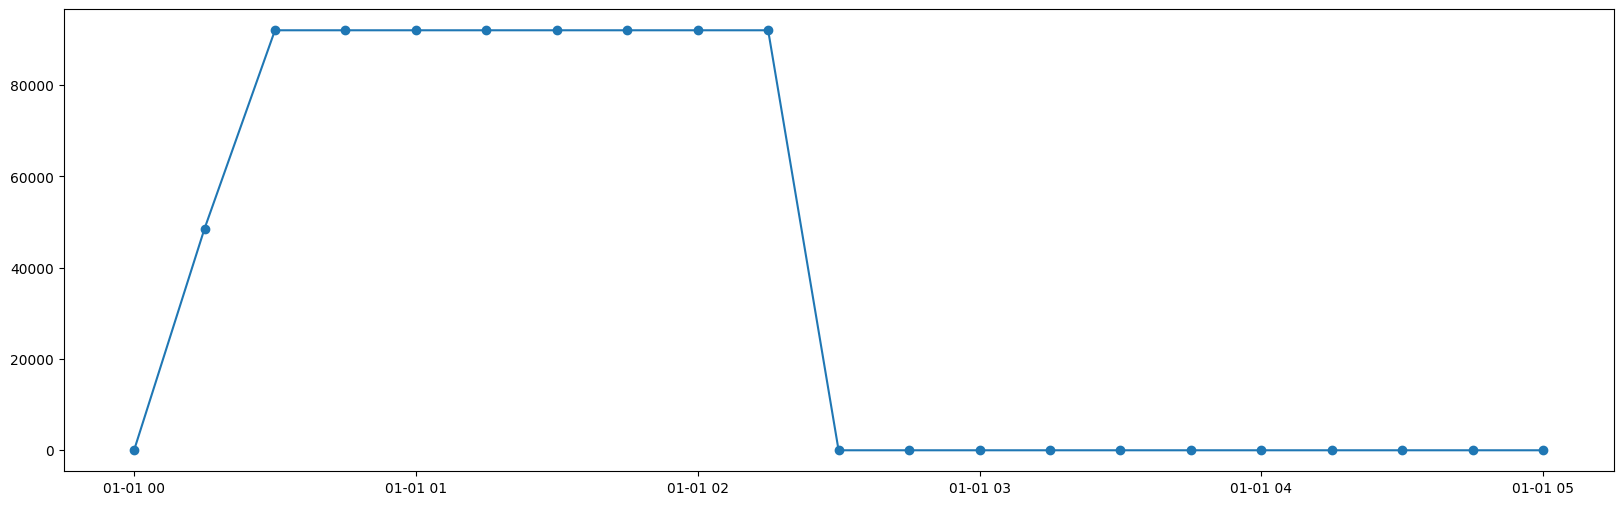

In [25]:
plt.figure(figsize = [20,6])
plt.plot(df.loc['2022-01-01 00:00:00':'2022-01-01 05:00:00','CHP_Pth'], marker = 'o')
plt.xticks()
plt.show()

In [26]:
#The small kinks at the top occur when switching to P_nom after the 11th minute, measerd data and the chp reg model goes upto 100Kw.

In [27]:
print(f"Total fuel consumption = {df['CHPSim-0.CHP_0-fuel_m3'].sum():.1f}")

Total fuel consumption = 1765.7


# Boiler functioning

In [28]:
mask = [col for col in df.columns if col.startswith('Boiler')]
mask

['Boilersim-0.BOILER_0-Q_Demand',
 'Boilersim-0.BOILER_0-mdot',
 'Boilersim-0.BOILER_0-temp_out',
 'Boilersim-0.BOILER_0-P_th',
 'Boilersim-0.BOILER_0-fuel_m3']

Text(0.5, 1.0, 'Boiler power')

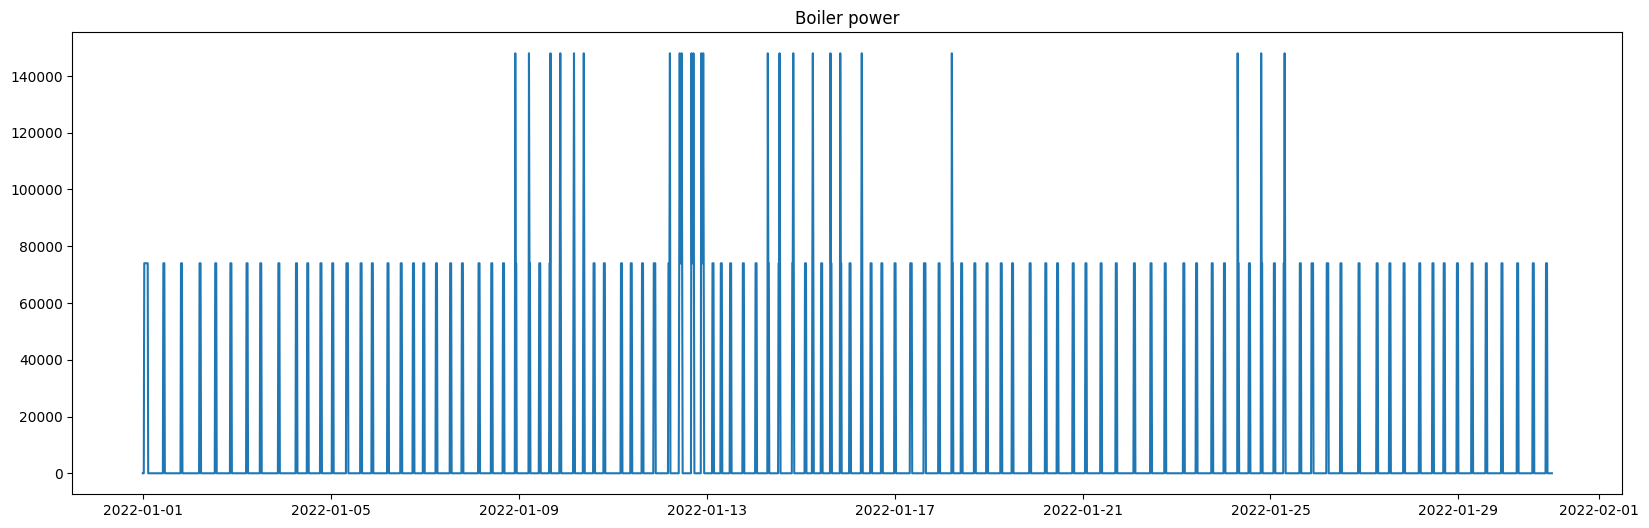

In [29]:
plt.figure(figsize = [20,6])
plt.plot(df['Boilersim-0.BOILER_0-P_th'])
plt.title("Boiler power")

Text(0.5, 1.0, 'Boiler mass flow')

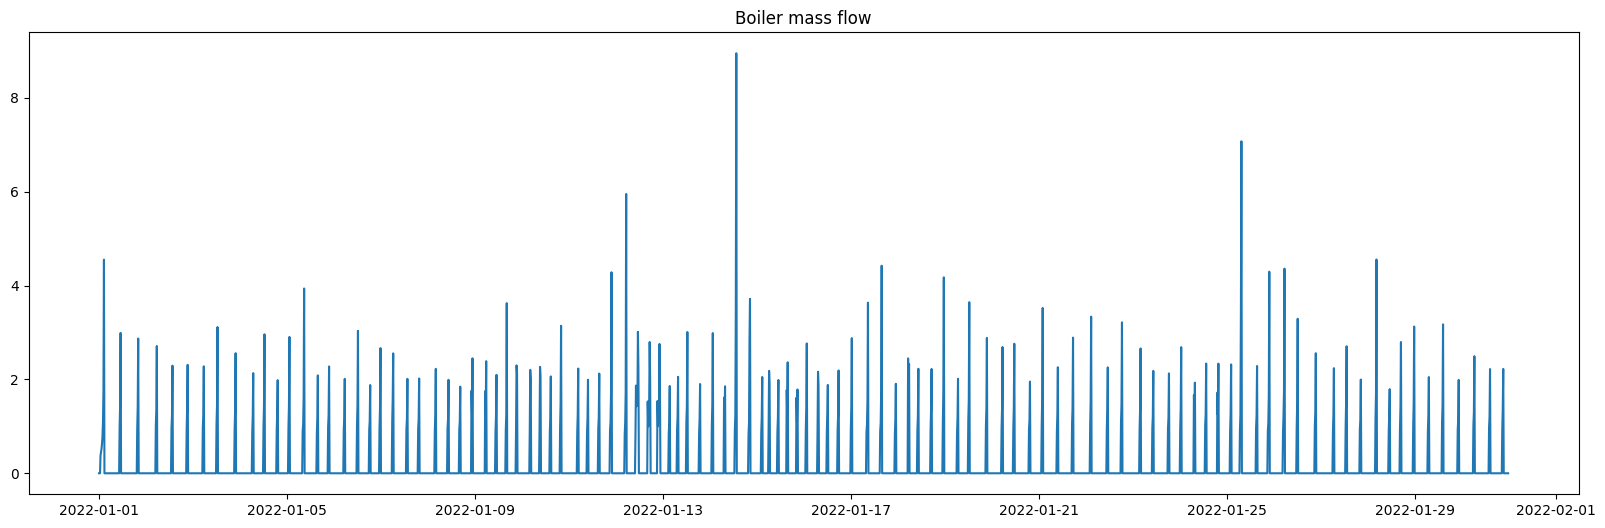

In [30]:
plt.figure(figsize = [20,6])
plt.plot(df['Boilersim-0.BOILER_0-mdot'])
plt.title("Boiler mass flow")

In [31]:
# df.to_csv('boiler_new connection.csv')

# Aggregated plot

In [32]:

fig = go.Figure()

# ----------------------------------------------------------------Power plots---------------------------------------------
fig.add_trace(go.Scatter(
    y=df['hp_supply'],
    x = df.index,
    mode='lines',
    name='Heat pump',
    line=dict(color='blue', shape="hv")
))

# Second plot (Boiler Simulation)
fig.add_trace(go.Scatter(
    y=df['chp_supply'],
    x = df.index,
    mode='lines',
    name='CHP-P_th',
    line=dict(color='red', shape="hv"),
    # yaxis='y2'  # Associate it with a second subplot
))

fig.add_trace(go.Scatter(
    y=df['Boilersim-0.BOILER_0-P_th'],
    x = df.index,
    mode='lines',
    name='Boiler',
    line=dict(color='green', shape="hv"),
    # yaxis='y2'  # Associate it with a second subplot
))

fig.add_trace(go.Scatter(
    y=df['P_hr'],
    x = df.index,
    mode='lines',
    name='Heating rods',
    line=dict(color='yellow', shape="hv"),
    # yaxis='y2'  # Associate it with a second subplot
))
#----------------------------------------------------------------Temp plots-----------------------------------------------------------
fig.add_trace(go.Scatter(
    y=df['heatout_T'],
    x = df.index,
    mode='lines',
    name='Heatout_Temp',
    line=dict(color='magenta', shape="hv"),
    yaxis='y2'  # Associate it with a second subplot
))

fig.add_trace(go.Scatter(
    y=df['HWTSim2_sensor0_T'],
    x = df.index,
    mode='lines',
    name='Tank[2]_bottom_temp',
    line=dict(color='cyan', shape="hv"),
    yaxis='y2'  
))

fig.add_trace(go.Scatter(
    y=df['HWTSim2_sensor2_T'],
    x = df.index,
    mode='lines',
    name='Tank[2]_Top_temp',
    line=dict(color='orange', shape="hv"),
    yaxis='y2'  
))

fig.add_trace(go.Scatter(
    x=[df.index.min(), df.index.max()],  
    y=[65, 65],  # Constant y-value
    mode="lines",
    name="T_sp_h",
    line=dict(color="lime", dash="dash"),
    yaxis="y2"  
))

#---------------------------------------------------------------Heat Demand in KW-----------------------------------------------------

fig.add_trace(go.Scatter(
    y=df['Heat Demand [KW]'],
    x = df.index,
    mode='lines',
    name='Heat Demand',
    line=dict(color='rgba(28, 227, 0, 0.878)', shape="hv"),
    yaxis='y1'  
))




# --------------------------------------------------------------Chp uptime plots -------------------------------------
# fig.add_trace(go.Scatter(
#     y=df['CHPSim-0.CHP_0-chp_uptime'],
#     x = df.index,
#     mode='lines',
#     name='chp uptime',
#     line=dict(color='cyan', shape="hv"),
#     yaxis='y3'  # Associate it with a second subplot
# ))

# fig.add_trace(go.Scatter(
#     y=df['CHPSim-0.CHP_0-chp_uptime'],
#     x = df.index,
#     mode='lines',
#     name='chp uptime from controller',
#     line=dict(color='lime', shape="hv"),
#     yaxis='y3'  # Associate it with a second subplot
# ))
#------------------------------------------------------------------------------------------------------
fig.update_layout(
    height=600,  # Total height of the figure
    showlegend=True,
    xaxis=dict(title='Time'),
    yaxis=dict(title='Power in W'),
    yaxis2=dict(
        title='Temperature',
        overlaying='y',  # Overlay y-axis for second subplot
        side='right',
        anchor='free',
        position=1
    ),
    yaxis3 = dict(title='uptime in minutes',
        overlaying='y',  # Overlay y-axis for second subplot
        side='right',
        anchor='free',
        position=1)
)

fig.show()


# Misc


In [33]:
sum(df['HWTSim2_sensor2_T'] - df['heatout_T'])

-46.43475280423809

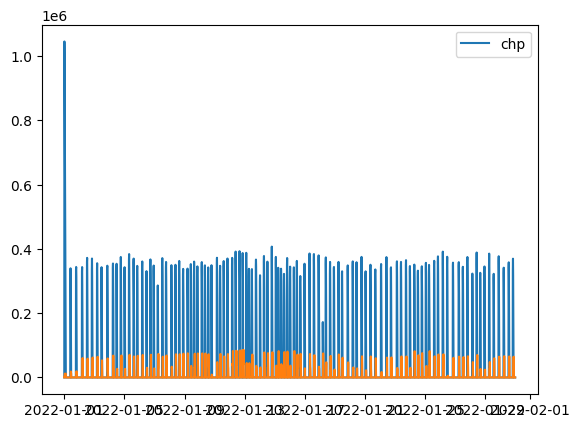

In [34]:
plt.plot(df['chp_demand'], label = 'chp')
plt.plot(df['Boilersim-0.BOILER_0-Q_Demand'])
plt.legend()


In [35]:


fig = go.Figure()

# First plot (Controller Simulation)
fig.add_trace(go.Scatter(
    y=df['chp_demand'],
    x = df.index,
    mode='lines',
    name='chp',
    line=dict(color='blue')
))

# Second plot (Boiler Simulation)
fig.add_trace(go.Scatter(
    y=df['Boilersim-0.BOILER_0-Q_Demand'],
    x = df.index,
    mode='lines',
    name='boiler',
    line=dict(color='red'),
    # yaxis='y2'  # Associate it with a second subplot
))

    # yaxis='y2'  # Associate it with a second subplot

# Update layout to create subplots
fig.update_layout(
    height=600,  # Total height of the figure
    showlegend=True,
    xaxis=dict(title='Time'),
    yaxis=dict(title='Power in W'),
    # yaxis2=dict(
    #     title='Boiler Simulation',
    #     overlaying='y',  # Overlay y-axis for second subplot
    #     side='right',
    #     anchor='free',
    #     position=1
    # )
)

fig.show()
